Team Gordon

Student Name	Student Number
 Alisha Sahota	20497348
 Anthony Ramelo	20499391
 Chris Wu	10182394
 Elizabeth Zhang	20161231
 Emily Zhao	10096273
 Sam Hossain	20466500


Explained variance by PCA components:
[0.23176036 0.13222931 0.11021725 0.10113842 0.08011367 0.07766502
 0.0732727  0.06424185 0.05395829]
Optimal number of clusters: 5
Silhouette Score for KMeans with k=5: 0.2518


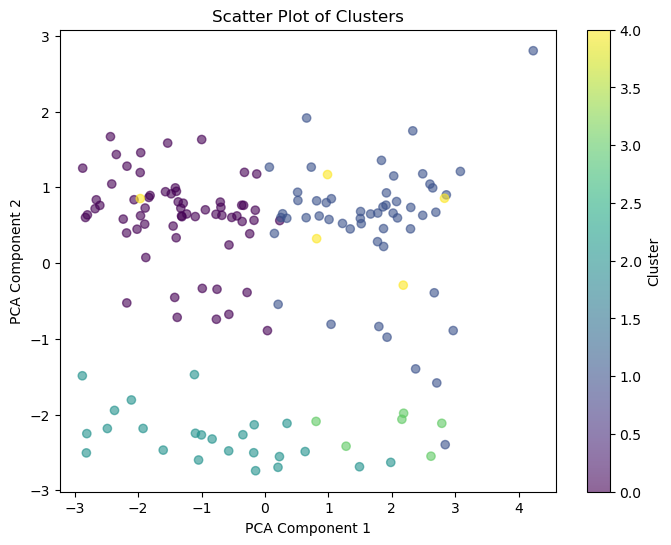

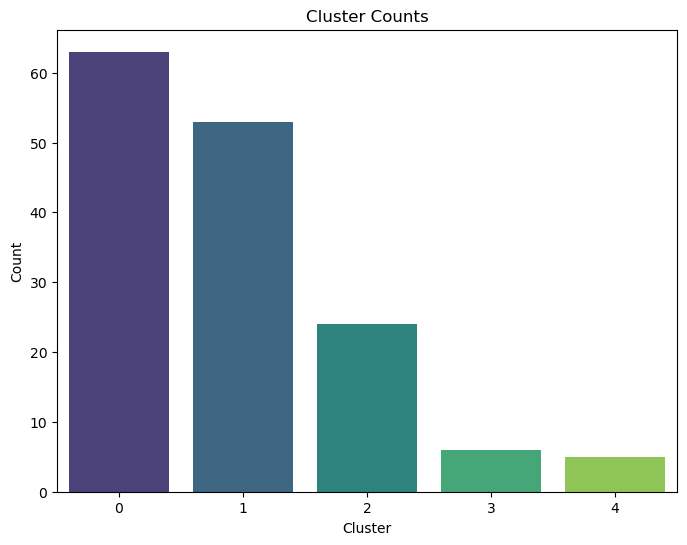

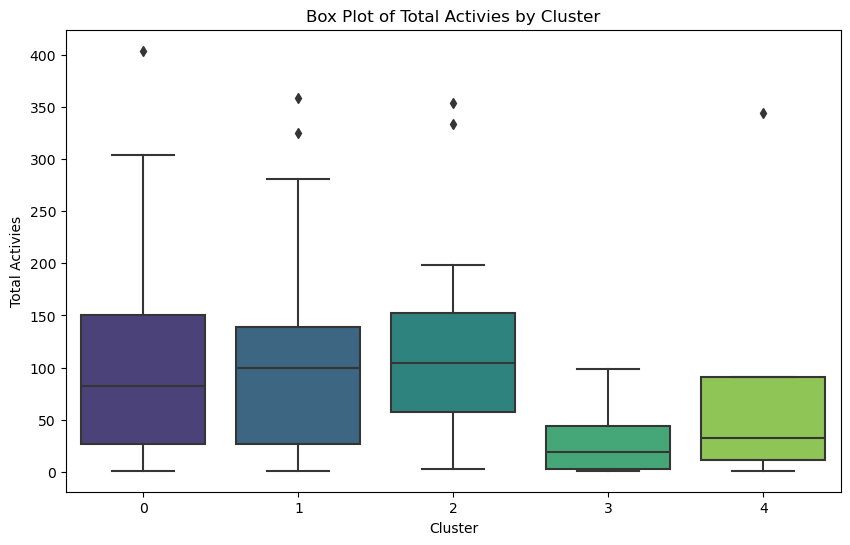

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os

# ==========================
# Load the Data
# ==========================
dfcrosssection = pd.read_excel('Data 3 - October, 2024.xlsx', sheet_name='Parachute - Cross Section')
dfcrosssection.columns = dfcrosssection.columns.str.strip()  # Remove extra spaces

# Ensure "Total Activities" column exists
if 'Total Activities' in dfcrosssection.columns:
    total_activities_col = 'Total Activities'
elif 'Total Activies' in dfcrosssection.columns:
    total_activities_col = 'Total Activies'
else:
    raise ValueError("Column 'Total Activities' or 'Total Activies' not found.")

# Drop rows with missing "Total Activities"
dfcrosssection = dfcrosssection[dfcrosssection[total_activities_col].notna()]

# Save the ID column separately for reference
dfcrosssection['ID'] = dfcrosssection['ID'].astype(str)
ids = dfcrosssection['ID']

# Preserve original dataset for reference
df_original = dfcrosssection.copy()

# Remove unnecessary columns
columns_to_remove = [
    "Aptitude for change Score", "Financial Literacy Score", "Self Assessments", "Quiz Count", "Mood Count",
    "Inspiration Count", "Average total activities per month", "Average activities per day", "Disbursement Date",
    "Province", "Loan Payment Type", "Loan Maturity Date", "City", "Postal Code", "Date of Birth", "ID"
]
dfcrosssection = dfcrosssection.drop(columns=columns_to_remove, errors='ignore')

# ==========================
# Data Preprocessing
# ==========================
threshold = len(dfcrosssection) * 0.5
dfcrosssection = dfcrosssection.dropna(thresh=threshold, axis=1)

# Handle missing values
numeric_cols = dfcrosssection.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='mean')
dfcrosssection[numeric_cols] = imputer_num.fit_transform(dfcrosssection[numeric_cols])

categorical_cols = dfcrosssection.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')
dfcrosssection[categorical_cols] = imputer_cat.fit_transform(dfcrosssection[categorical_cols])

# Encode categorical variables
df_encoded = pd.get_dummies(dfcrosssection, columns=categorical_cols, drop_first=True)

# Scale the features
scaler = StandardScaler()
df_encoded[df_encoded.columns] = scaler.fit_transform(df_encoded[df_encoded.columns])

# ==========================
# Clustering and Results
# ==========================
pca = PCA(n_components=0.8, random_state=42)
df_pca = pd.DataFrame(pca.fit_transform(df_encoded))

# Explained variance
print("Explained variance by PCA components:")
print(pca.explained_variance_ratio_)

# Elbow Method
wcss = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_pca)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(df_pca, labels)
    silhouette_scores.append(silhouette_avg)

# Determine optimal clusters
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Optimal number of clusters: {optimal_k}")
print(f"Silhouette Score for KMeans with k={optimal_k}: {max(silhouette_scores):.4f}")

# Perform KMeans with optimal_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_encoded['Cluster'] = kmeans.fit_predict(df_pca)
df_original['Cluster'] = df_encoded['Cluster']

# Save the clustered dataset
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
df_original.to_csv(f"{output_dir}/final_output_with_clusters.csv", index=False)

# ==========================
# Visualizations
# ==========================
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=df_encoded['Cluster'], cmap='viridis', alpha=0.6)
plt.title('Scatter Plot of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.savefig(f"{output_dir}/scatter_plot_clusters.png")
plt.show()

plt.figure(figsize=(8, 6))
cluster_counts = df_encoded['Cluster'].value_counts()
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Cluster Counts')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.savefig(f"{output_dir}/cluster_counts.png")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_original, x='Cluster', y=total_activities_col, palette='viridis')
plt.title(f'Box Plot of {total_activities_col} by Cluster')
plt.xlabel('Cluster')
plt.ylabel(total_activities_col)
plt.savefig(f"{output_dir}/boxplot_total_activities_by_cluster.png")
plt.show()